Bu kodun hazırlanmasında Unsloth dokümantasyonundan yararlanmıştır.

In [1]:
!pip install unsloth trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 8.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 100.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 15.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.6 MB/s eta 0:00:00:00:0100:01
  

Büyük Dil Modellerini olduğu gibi eğitmek için uzun zaman, fazla kaynak ve büyük veriye ihtiyaç vardır. Bu sorunun önüne geçmek için bir takım kütüphaneler ve yöntemler kullanılır. Kullanılan kütüphanelerden birisi de unsloth kütüphanesidir. Bu kütüphane istenilen açık kaynaklı büyük dil modellerini sisteme çeker ve çeşitli yöntemler sayesinde yüksek GB gereken veriyi küçülterek eğitimin kolay gerçekleştirilmesini ve çıktıların istenilen yerlerde saklanmasını sağlar. Unsloth kütüphanesinden kısaca bahsettiğimize göre yöntemlere değinelim.

Bahsedilen ve kodta geçen yöntemlerden birisi de 4bit kuantizasyon tekniğidir. Model ağırlıkları genellikle 32 bit float ya da 16 bit float olarak saklanır. Büyük modellerde bu ağırlıklar sistemde çok fazla yer kaplar. 4 bit kuantizasyon yöntemi ile ağırlıklar normalden 4 ile 8 kat daha az yer kaplar. Ancak saklanan verinin kesinliğinin (precision) düşük 16 ve 32 bitliğe göre daha düşük olmasından dolayı sonuçlar teorik olarak biraz düşük çıkabilir. Ancak modern tekniklerle (örn. Quantization-Aware Training, GPTQ) kayıp minimuma indirilebilir.

## Quantization-Aware Training (QAT)

Modeli FP32 veya FP16 olarak eğitirken aynı zamanda ağırlıkların kuantize edilmiş hallerini de simüle eder. Eğitim sırasında ağırlıklar hem float hem de kuantize edilmiş halde bulunur. Bu yöntemin amacı kuantizasyon sonrası performans kaybını önceden tahmin etmek ve minimize etmektir. Forward pass sırasında model, kuantize edilmiş ağırlıkları kullanır. Backpropagation sırasında gradient’ler float ağırlıklar üzerinden hesaplanır. Böylece model, kuantize edilmiş ağırlıkların getirdiği hataya "alışır" ve performans kaybı minimize edilir. Eğitim süresi artar, çünkü kuantizasyon simülasyonu ek hesaplama gerektirir.


## GPTQ (Gradient-based Post-Training Quantization)

Büyük modelleri eğittikten sonra kuantize eder. Gradient kullanarak 4-bit veya 3-bit kuantizasyon sırasında hatayı minimize eder. Model eğitildikten sonra ağırlıklar alınır. GPTQ, ağırlıkları grup veya blok bazlı olarak kuantize eder.
Kuantizasyon hatasını minimize etmek için local gradient’ler kullanılır (gradient descent ile optimize edilir, ama model yeniden eğitilmez). Sonuç olarak 4-bit veya 3-bit ağırlıklar, orijinal model performansına çok yakın bir doğrulukla elde edilir. Modeli yeniden eğitmek gerekmez. Post-training adımı, özellikle büyük modellerde zaman alabilir.

In [ ]:
# Model işlemleri için unsloth kütüphanesi kullanılır.
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported

# Huggingface verisi için datasets kullanılır.
from datasets import load_dataset

# Açık kaynak LLM'lerin büyük çoğunluğu zaten PyTorch kullanır.
import torch

# Model eğitimi
from trl import SFTTrainer
from transformers import TrainingArguments

In [2]:
max_seq_len = 2048
# Memory kullanımını azaltmak için modeli 4 bit kuantize etmemiz gerekir.
load_in_4bit = True 
model_name = 'unsloth/Meta-Llama-3.1-8B'
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_len,
    dtype = torch.float16,
    load_in_4bit = load_in_4bit
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-10-17 12:21:39.126483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760703699.365568      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760703699.433948      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.4: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [3]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((409

Modeli eğitmeden önce bütün modeli eğitmek fazlaca yer ve zaman içereceğinden dolayı PEFT (Parameter Efficient Fine Tuning) tekniğini kullanırız. Bu bize belli katmanlar üzerinde model eğitimini sağlar ve bütün modeli eğitmektense modelin başlı kısımlarını eğitiriz. Ayrıca PEFT ile günümüzde sıkça kullanılan ve PEFT'in alt yöntemlerinden biri olan LORA (Low Rank Adaptation) tekniğini de sıkça kullanırız.

### PEFT’in alt yöntemleri:

 PEFT bir çatı kavramdır. Altında farklı teknikler vardır:

###
Teknik	        Açıklama

LoRA:	        En popüler yöntem. Ağırlıklara düşük-rank matris ekler.

Prefix Tuning:	Girdi dizisine “özel tokenlar” ekleyerek ayar yapar.

Adapter Tuning:	Her katmana küçük ek sinir ağı modülleri ekler.

Prompt Tuning:	Modeli yeniden eğitmeden, giriş metnine sanal promptlar ekler.
###

Bugün en çok kullanılanı LoRA’dır.

### LoRA (Low-Rank Adaptation)

LoRA, büyük matrisleri tamamen güncellemek yerine, onlara küçük, düşük-rank eklemeler yapar. Bir model katmanında normalde şöyle bir ağırlık vardır:

𝑦 = 𝑊 * 𝑥

Burada 𝑊 genelde çok büyük (örneğin 4096×4096 boyutunda) bir matristir. LoRA bunu şu şekilde değiştirir:

𝑦 =(𝑊+𝐴𝐵)𝑥

Burada 𝐴 ve 𝐵 küçük, düşük-rank matrislerdir. 𝑟 bu matrislerin boyutunu belirleyen parametre (örneğin 4, 8, 16). Eğitim sırasında 𝑊 sabit kalır (freeze). Sadece 𝐴 ve 𝐵 öğrenilir. Bu sayede parametre sayısı 100 kat azalabilir. Performans çoğu zaman aynı kalır veya çok az düşer. Bu sayede eğitilecek parametre sayısı azalır, bellekte tasarruf sağlanır ve eğitim hızlanır.

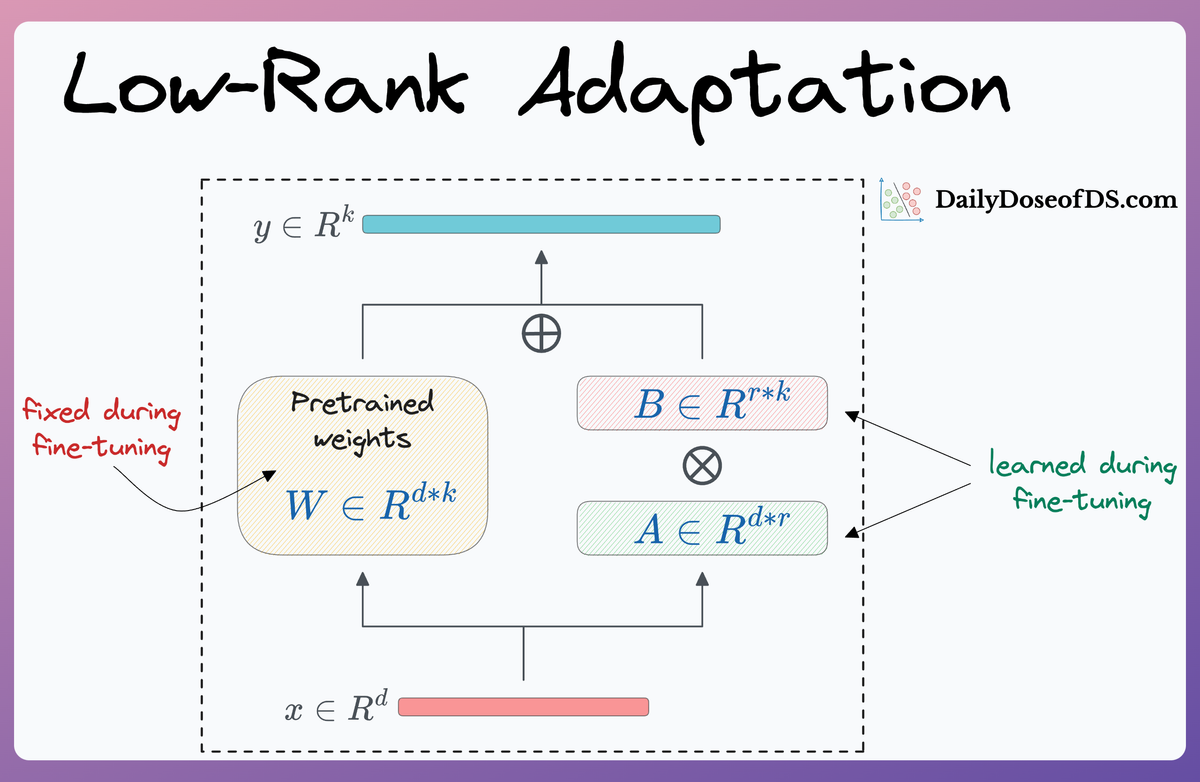

### PEFT + LoRA birlikte nasıl çalışır?

PEFT, “hangi parametreleri eğitelim?” sorusuna genel cevaptır. LoRA, bu stratejilerden biridir (en verimlisi). PEFT önceden eğitilmiş katmanları alır ve belirli modüllere LoRA ekler. LoRA ise bu katmanları eğitir. 

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    # Rank parametresidir. =! 0 olmalıdır. 8, 16, 32, 64, 128 değerleri önerilir.
    r = 16,
    # Eğitilecek modüller
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj',
                     'gate_proj', 'up_proj', 'down_proj'],
    #lora parametreleri ve bias
    # özellikle lora da A B matrisinin katsayısı olarak lora_alpha / rank seçilir.
    lora_alpha = 16,
    lora_dropout = 0,
    bias = 'none',
    use_gradient_checkpointing = 'unsloth',
    random_state = 3407,
    #rank stabilized lora aktif mi pasif mi olacak onu belirler.
    use_rslora = False,
    #LoftQ
    loftq_config = None,
    
)

Unsloth 2025.10.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad == True)
print(f"Model parameters: {params:,}")
print(f"Trainable model parameters: {trainable_params:,}")

Model parameters: 4,670,623,744
Trainable model parameters: 41,943,040


In [6]:
# Instruction modellerin verileri anlaması için bir prompta ihtiyacı vardır. Bu kod parçasında da promptu verip EOS_TOKEN ile
# sonlandırıyoruz yoksa model sonlandırma tokenı olmadığı için sonsuza kadar çalışır.
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""
# Sona EOS_TOKEN eklememiz gerekir.
EOS_TOKEN = tokenizer.eos_token 
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # EOS_TOKEN eklemezsek sonsuza kadar çalışır!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

README.md: 0.00B [00:00, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

In [7]:
# Trainer parametreleri
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_len,
    dataset_num_proc = 2, # dataset işlemlerinde 2 çekirdek kullan
    packing = False, # Kısa cümlelerde 5 kat daha hızlı çalışır.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        #lr kademeli olarak arttır
        warmup_steps = 5,
        num_train_epochs = 1, 
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", 
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/51760 [00:00<?, ? examples/s]

In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 51,760 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.765700
2,1.802200
3,1.829600
4,1.531900
5,1.620700
6,1.300400
7,1.249900
8,1.051400
9,1.232500
10,0.997800


In [9]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nContinue the fibonnaci sequence.\n\n### Input:\n1, 1, 2, 3, 5, 8\n\n### Response:\n13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765<|end_of_text|>']